In [1]:
import sys
sys.path.append('../')

import tensorflow as tf
import segmentation_models as sm

from MRIsegm.metrics import dice_coef
from MRIsegm.losses import DiceBCEloss
from MRIsegm.graphics import show_dataset, plot_history, show_prediction
from MRIsegm.datagenerators import DataGenerator

Segmentation Models: using `keras` framework.


In [2]:
BACKBONE = 'efficientnetb0'

SEED = 666
BATCH = 4


IMAGE_HEIGHT = 512
IMAGE_WIDTH =  512
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_OF_EPOCHS = 150

source_path = '../data/imgs'
label_path = '../data/labels'


In [3]:
train_generator = DataGenerator(batch_size=BATCH, 
                                source_path=source_path, 
                                label_path=label_path,
                                seed=SEED, aug=True,
                                validation_split=0.2, subset='training'
                               )
validation_generator = DataGenerator(batch_size=BATCH, 
                                     source_path=source_path, 
                                     label_path=label_path,
                                     seed=SEED, aug=False,
                                     validation_split=0.2, subset='validation'
                                    )

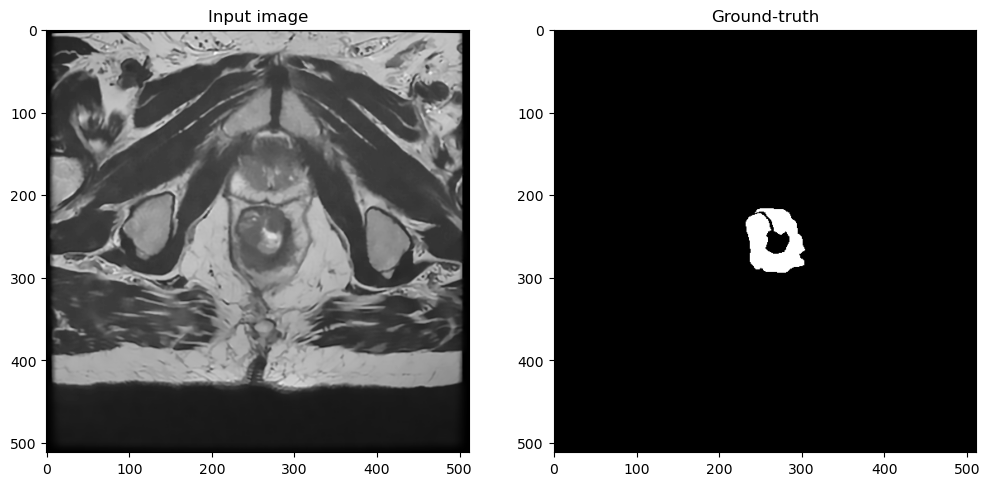

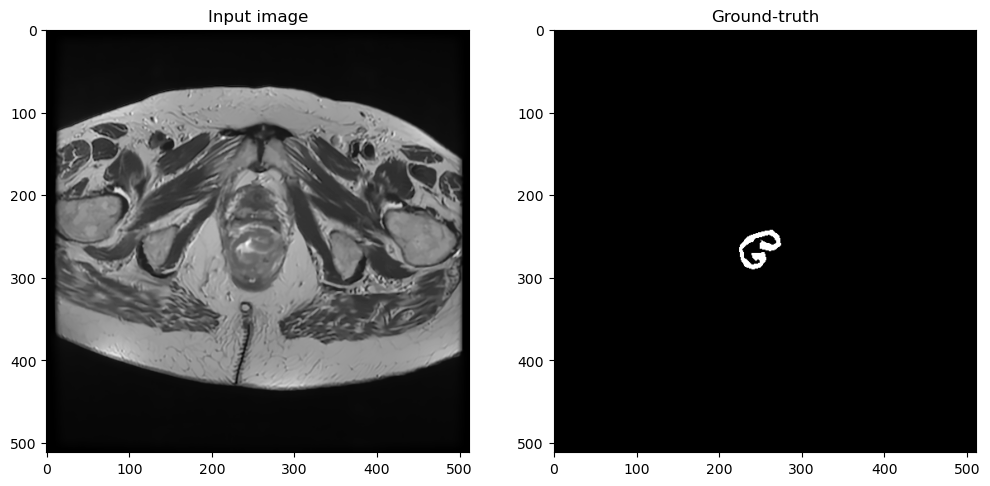

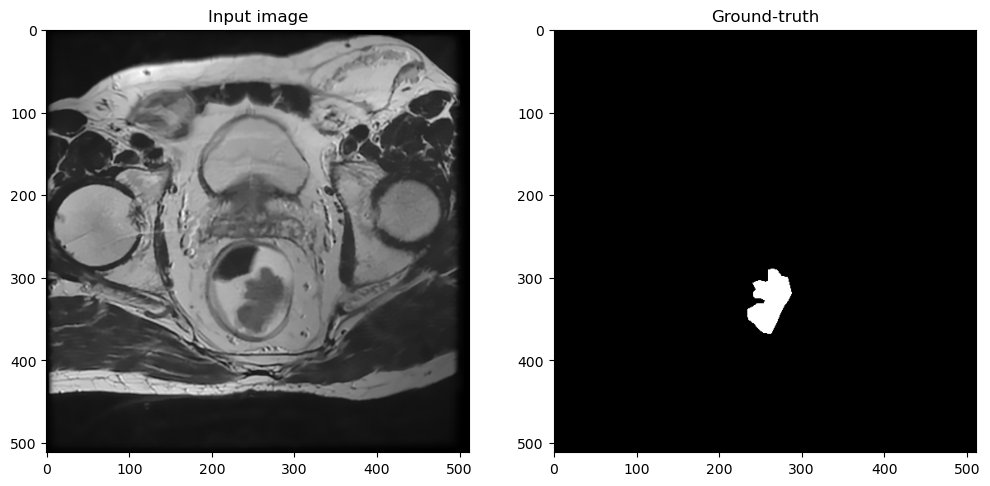

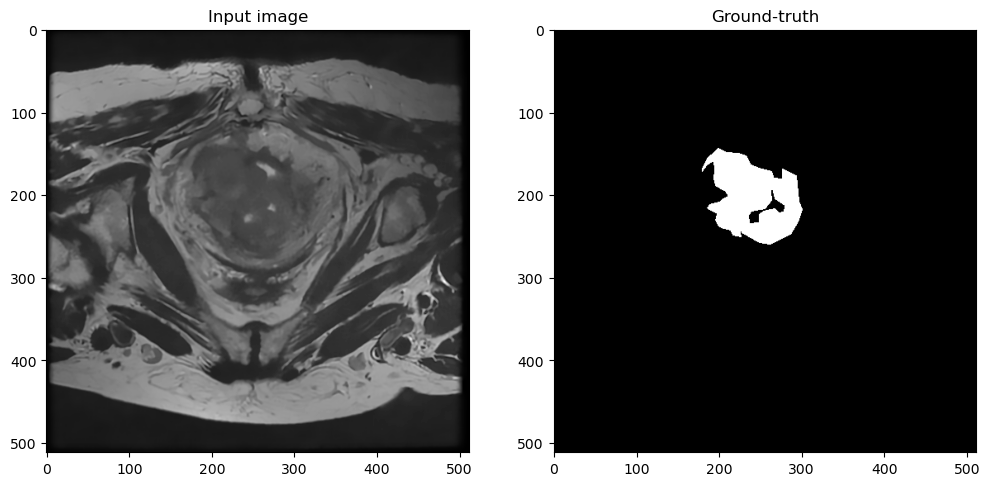

In [5]:
show_dataset(train_generator, 4)

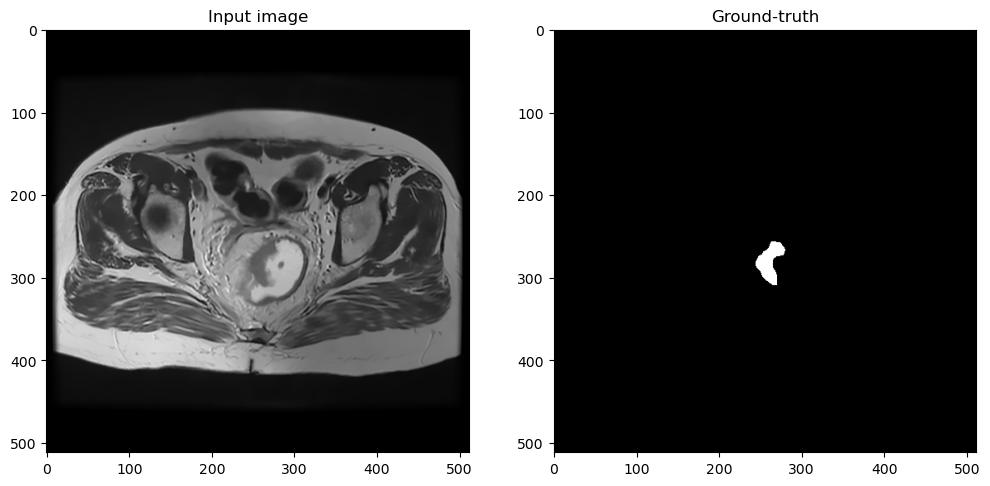

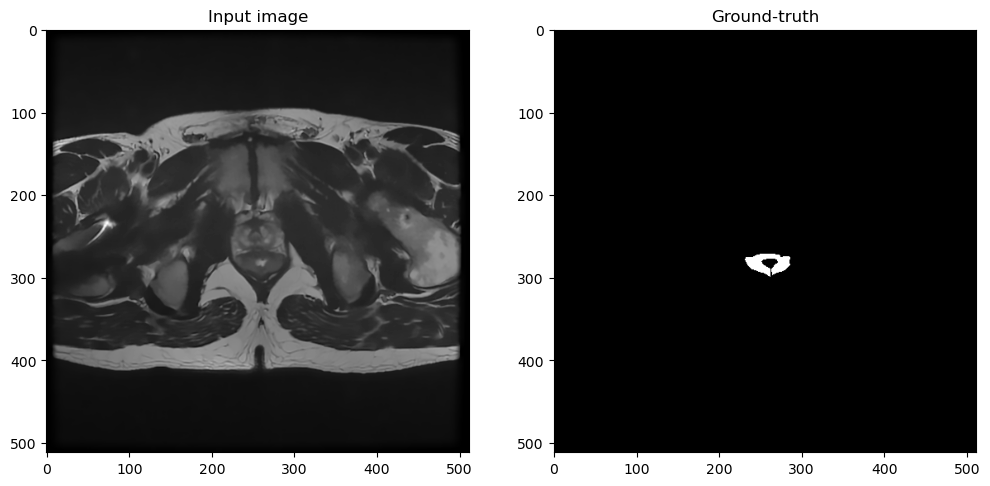

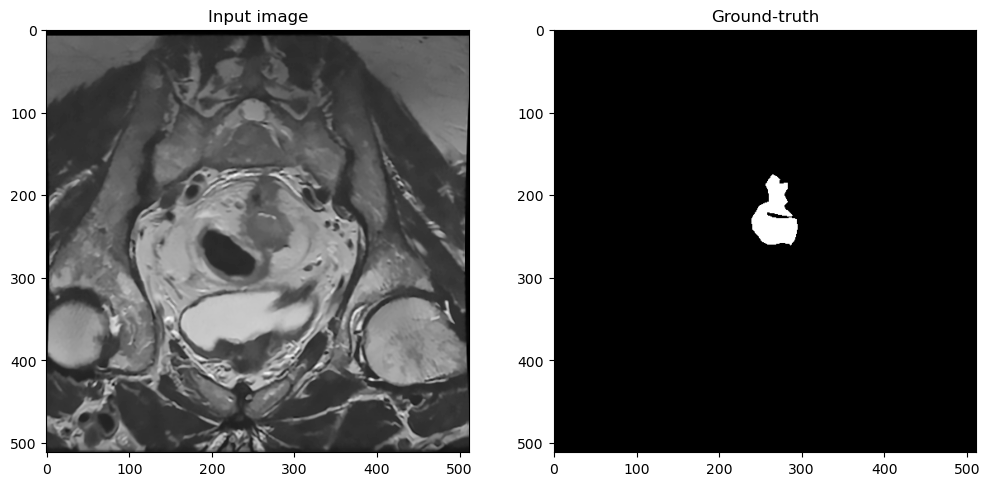

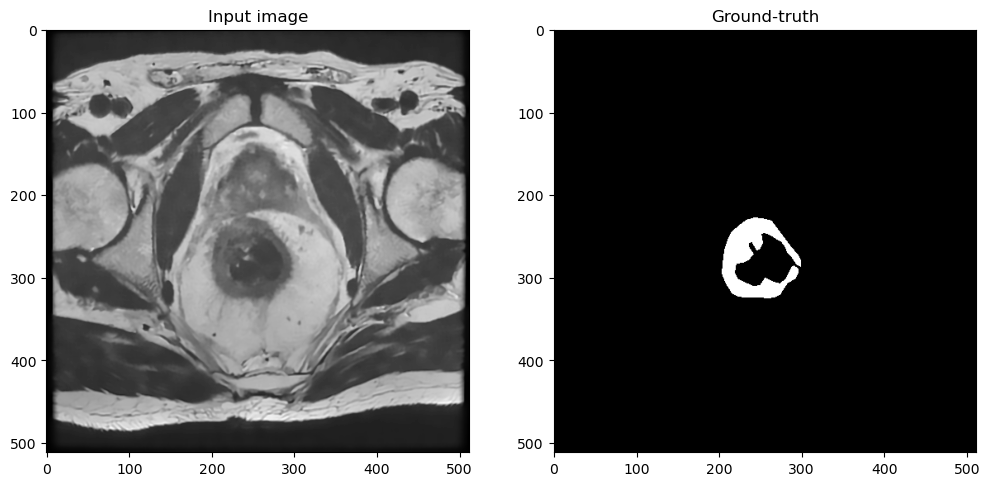

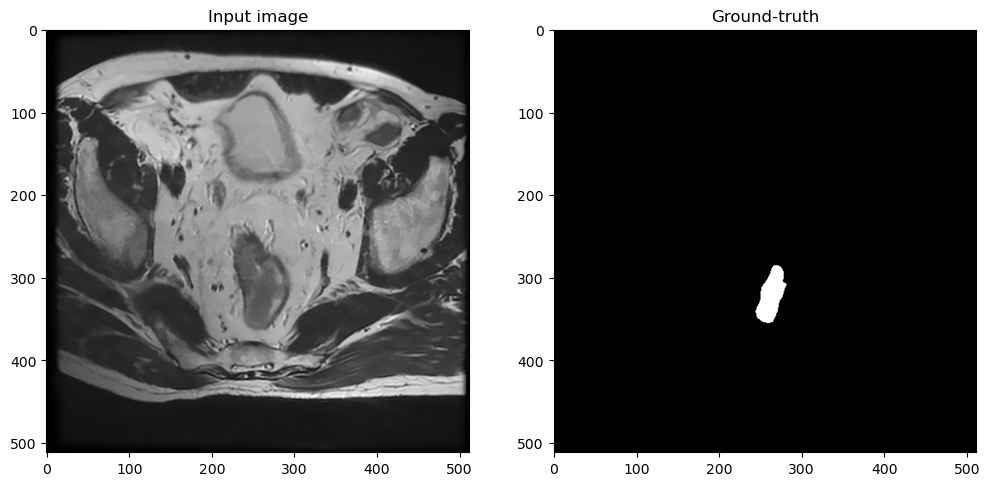

In [8]:
show_dataset(validation_generator, 5)

In [36]:
model = sm.Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1), encoder_weights=None, activation='sigmoid')

optimizer =  'adam'
    
# oss = DiceBCEloss

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
loss = dice_loss + (1 * focal_loss)

metrics = [  dice_coef ]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 32) 288         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [37]:
callbacks = [
                  # optional: tf.keras.callbacks.ModelCheckpoint('../data/models/checkpoints/' + model_name + '_checkpoint' + '.h5', save_best_only=True),
                  # optional: tf.keras.callbacks.CSVLogger( csv_dir + model_name + '.csv', separator=',', append=False),
                  # tf.keras.callbacks.ReduceLROnPlateau(),
                  tf.keras.callbacks.EarlyStopping(patience=11 , monitor='val_loss')
                  # optional: tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
]

history = model.fit(train_generator,
            steps_per_epoch=train_generator.num_data // BATCH, 
            validation_data=validation_generator, 
            validation_steps=validation_generator.num_data // BATCH,
            epochs=NUM_OF_EPOCHS,
            callbacks=callbacks)

Epoch 1/150
97/97 [==============================] - 206s 2s/step - loss: 1.0028 - dice_coef: 0.0403 - val_loss: 1.1273 - val_dice_coef: 1.5100e-04
Epoch 2/150
97/97 [==============================] - 193s 2s/step - loss: 0.7084 - dice_coef: 0.2560 - val_loss: 1.5249 - val_dice_coef: 0.0075
Epoch 3/150
97/97 [==============================] - 195s 2s/step - loss: 0.5851 - dice_coef: 0.3387 - val_loss: 2.3109 - val_dice_coef: 0.0461
Epoch 4/150
97/97 [==============================] - 180s 2s/step - loss: 0.5014 - dice_coef: 0.4200 - val_loss: 0.7365 - val_dice_coef: 0.2266
Epoch 5/150
97/97 [==============================] - 184s 2s/step - loss: 0.4804 - dice_coef: 0.4606 - val_loss: 0.6037 - val_dice_coef: 0.3248
Epoch 6/150
97/97 [==============================] - 180s 2s/step - loss: 0.4282 - dice_coef: 0.5199 - val_loss: 0.5543 - val_dice_coef: 0.4409
Epoch 7/150
97/97 [==============================] - 183s 2s/step - loss: 0.3930 - dice_coef: 0.5543 - val_loss: 0.4279 - val_dice_c

In [38]:
model_name = BACKBONE + f'_BTC={BATCH}_full_earlystop' 


if type(optimizer) == str: 
    model_name = model_name + f'_OPT={optimizer}' 
else:
    model_name = model_name + f'_OPT={optimizer._name}'


if type(loss) == str: 
    model_name = model_name + f'_LOSS={loss}' 
else:
    model_name = model_name + f'_LOSS={loss.__name__}'

print('model name: ', model_name)

model name:  efficientnetb0_BTC=4_full_earlystop_OPT=adam_LOSS=dice_loss_plus_1binary_focal_loss


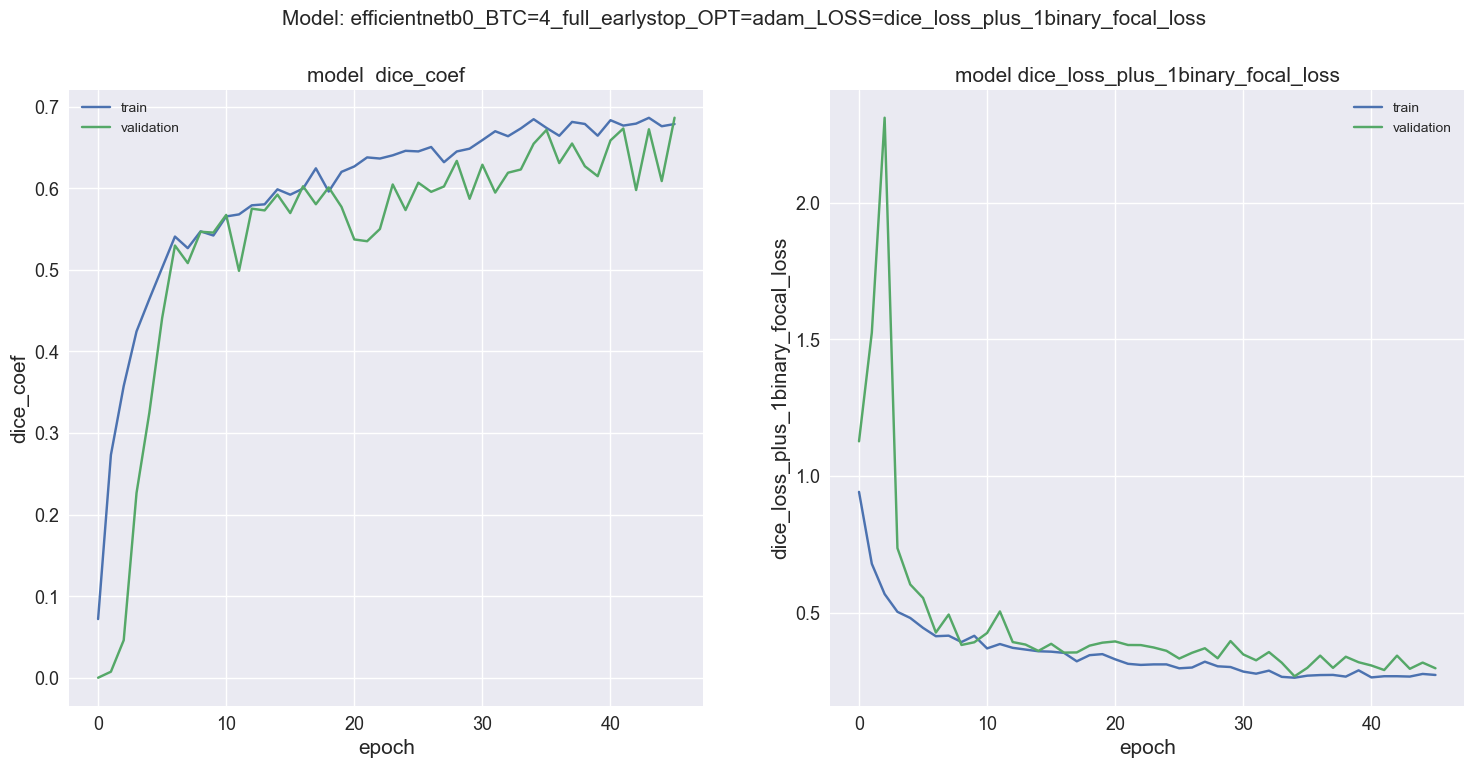

In [39]:
plot_history(model_name, history, metrics, loss, custom_loss=True, custom_metrics=True, figsize=(18,8),labelsize=13, path='../data/plots/' + model_name, save = True)

In [41]:
print(f"Evaluating on validation data ({validation_generator._num_data} images)")
evaluation = model.evaluate(validation_generator, batch_size=BATCH, steps=validation_generator._num_data // BATCH, return_dict=True)
print(evaluation)

Evaluating on validation data (97 images)
24/24 [==============================] - 20s 842ms/step - loss: 0.3065 - dice_coef: 0.6729
{'loss': 0.3065043091773987, 'dice_coef': 0.6728649139404297}


In [44]:
import json

with open('../data/evals/' + model_name + '_validation_eval.txt', 'w') as file:
     file.write(json.dumps(evaluation))

In [45]:
model.save('../data/models/' + model_name + '.h5')

/Users/giuseppefilitto/miniforge3/envs/tf2.5/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


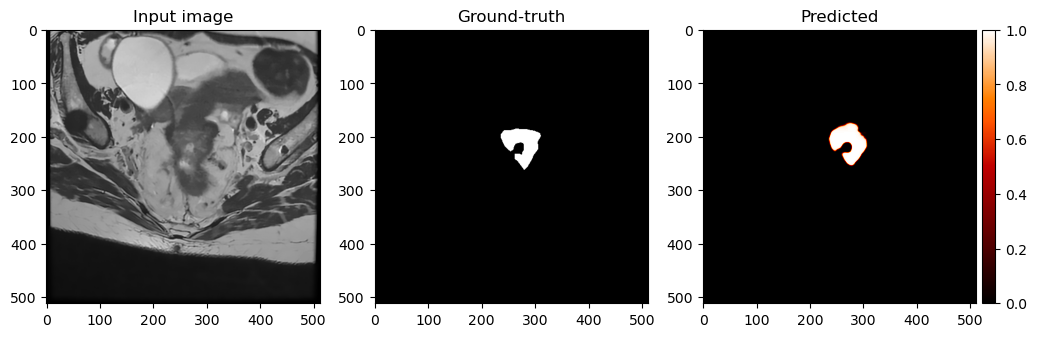

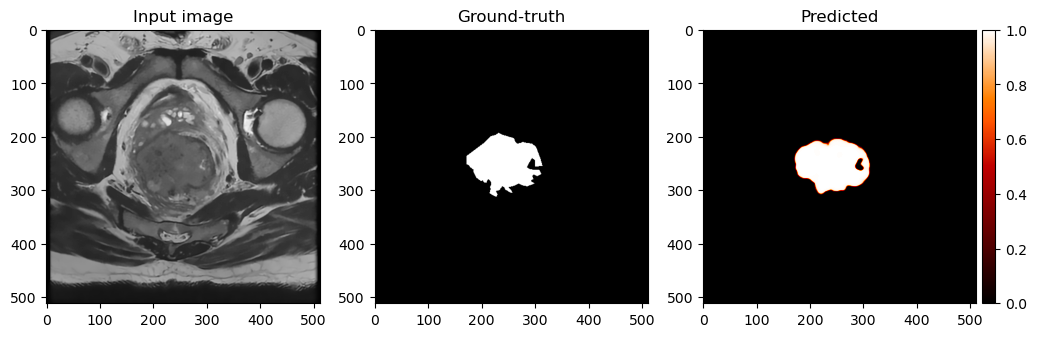

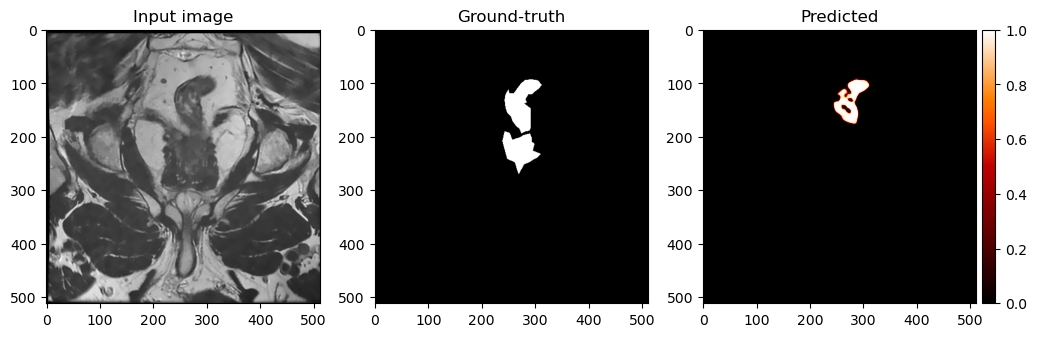

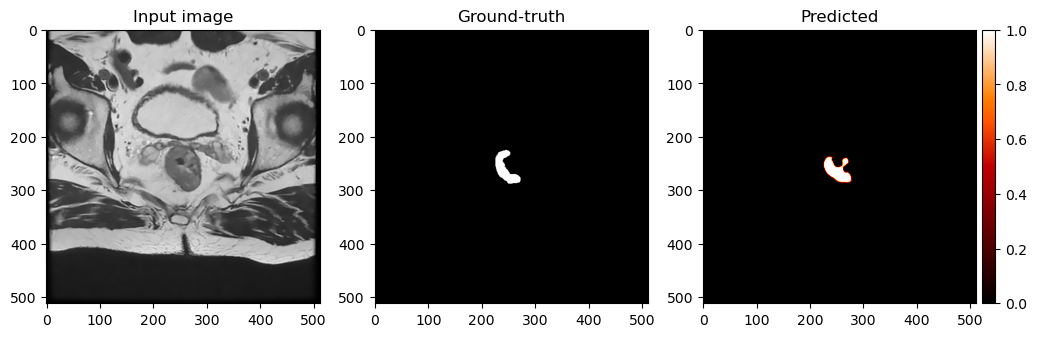

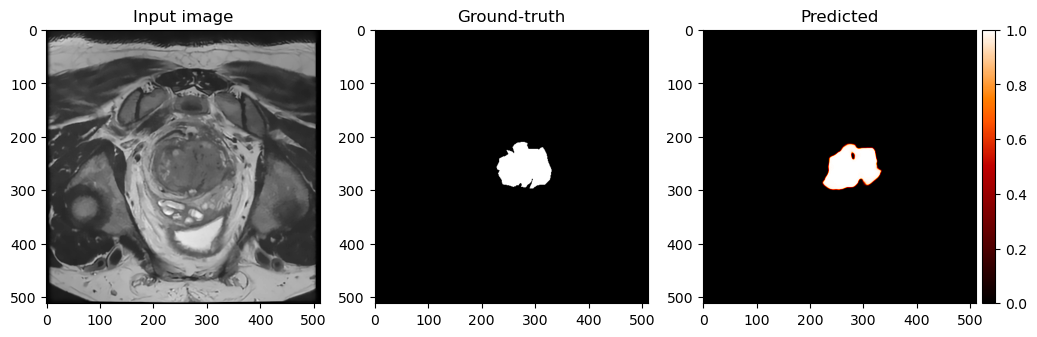

In [42]:
show_prediction(datagen=train_generator, model=model , num=5)

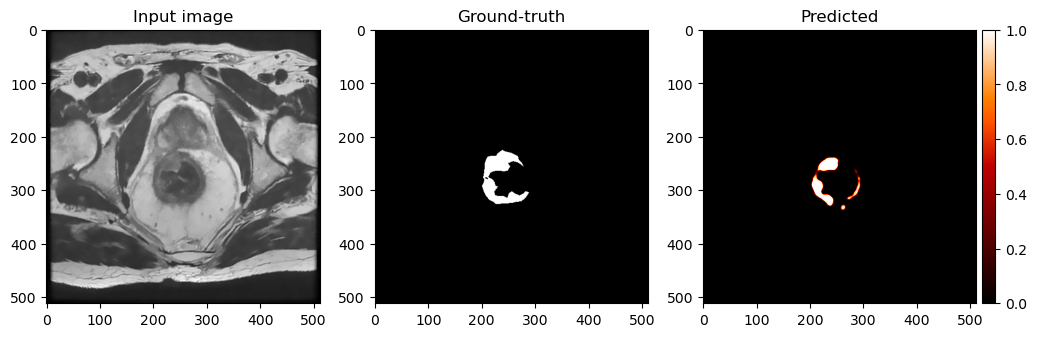

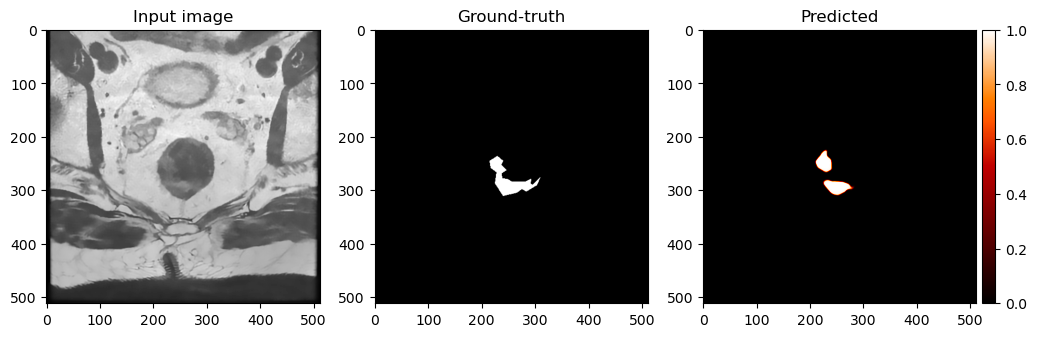

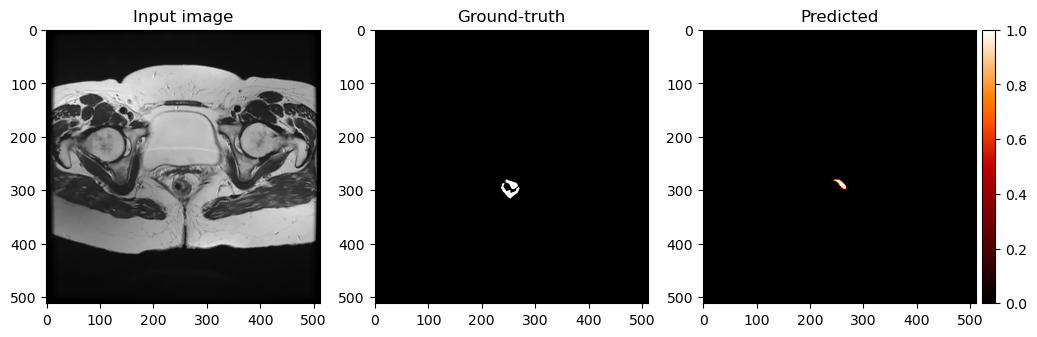

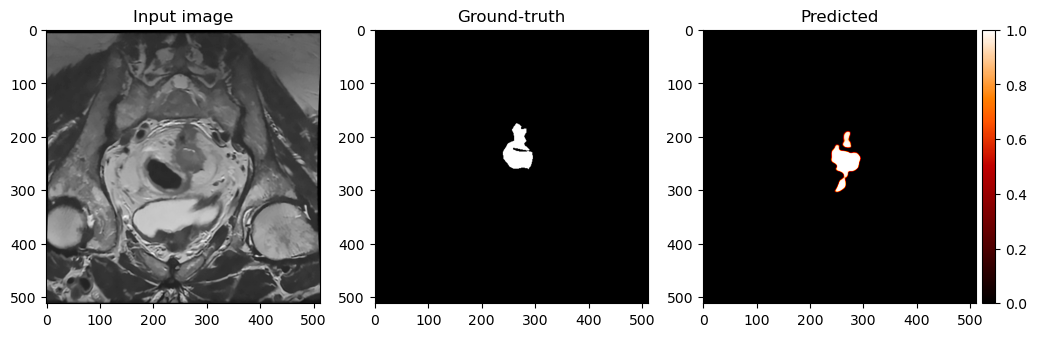

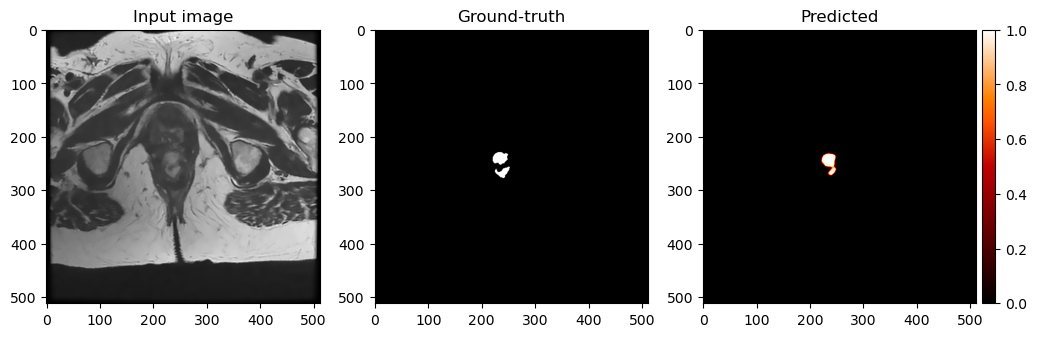

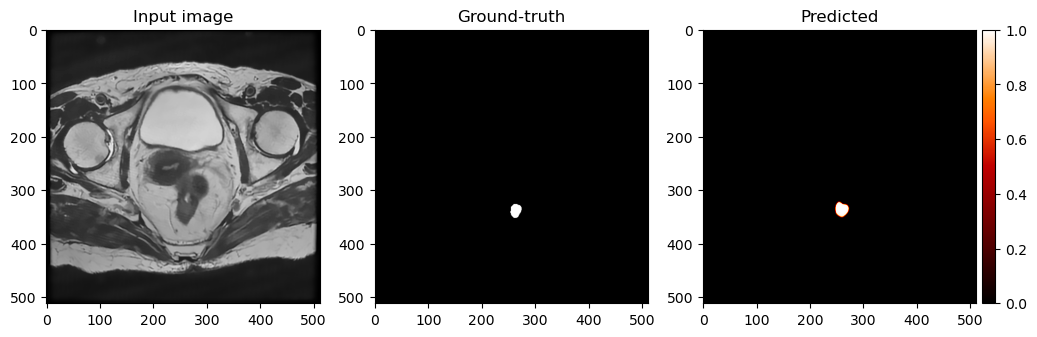

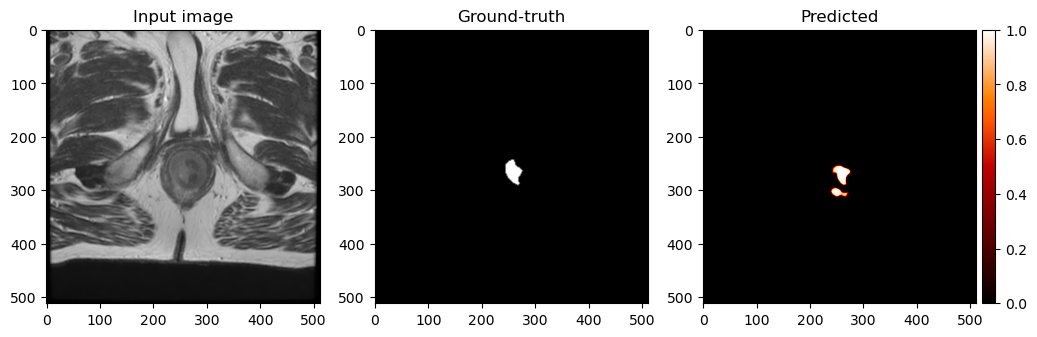

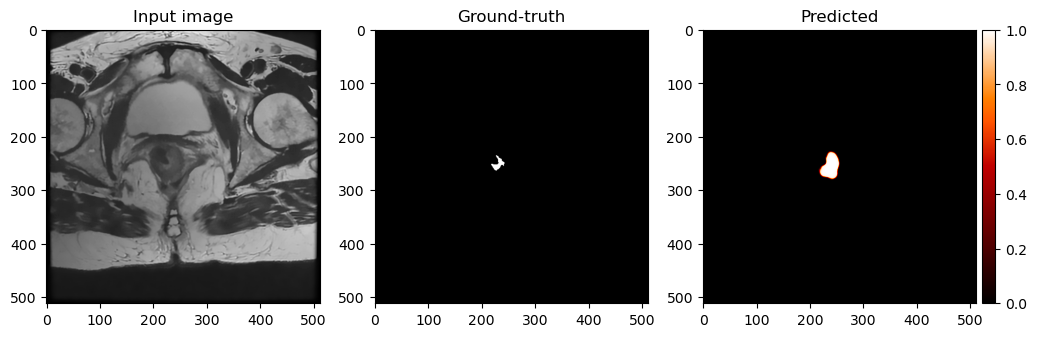

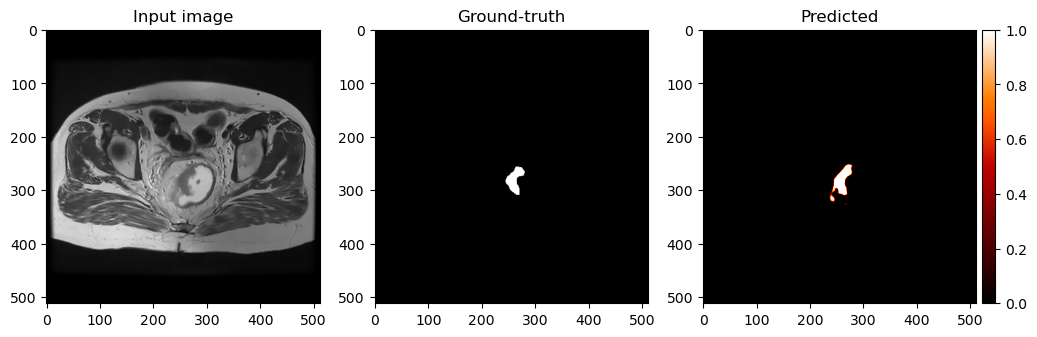

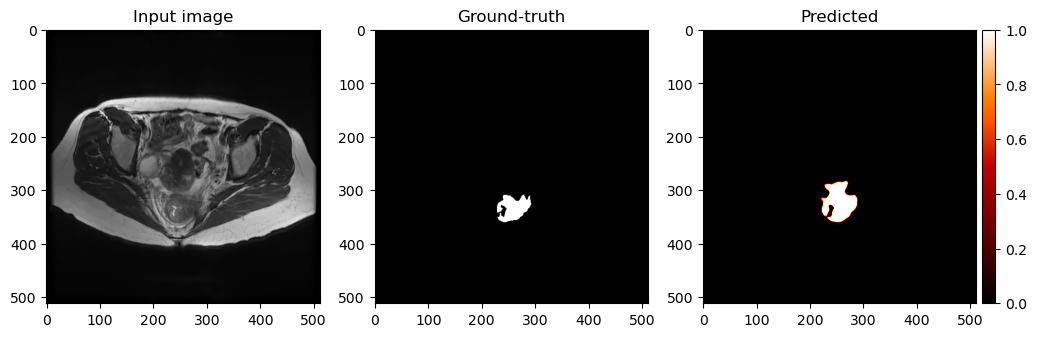

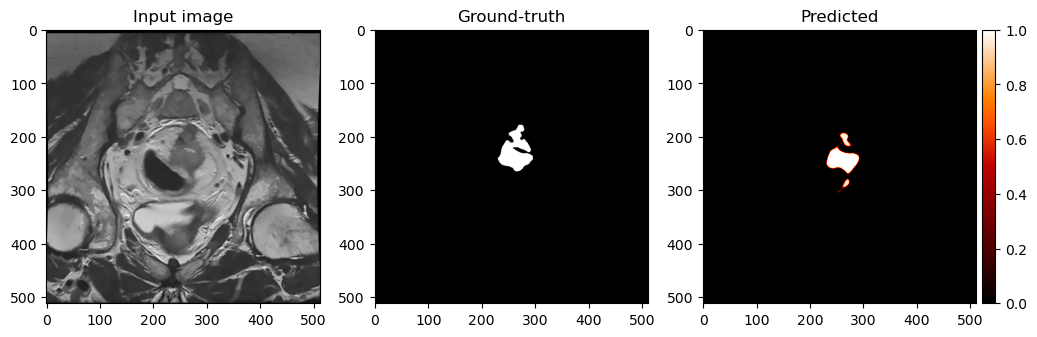

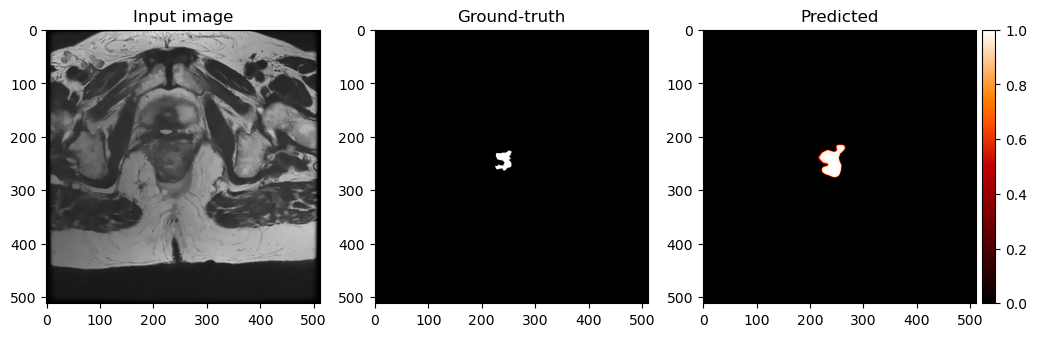

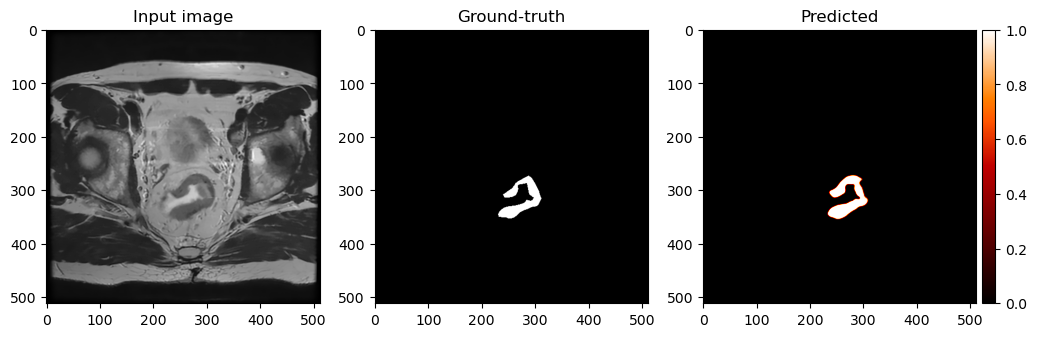

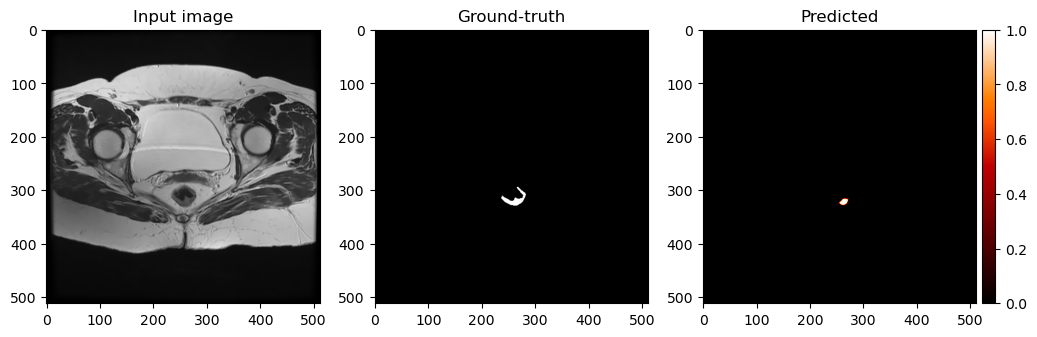

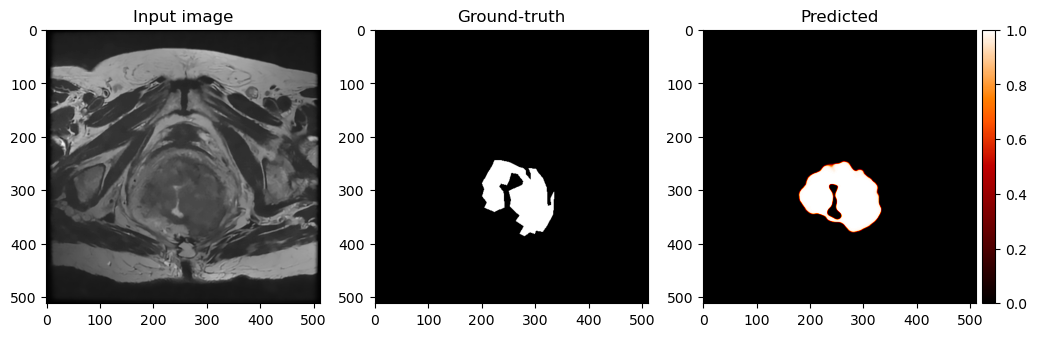

In [43]:
show_prediction(datagen=validation_generator, model=model , num=15)